In [26]:
import gzip
import json
import pickle
import scipy.sparse

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from scipy import spatial
from sklearn.decomposition import PCA

from lightfm import LightFM
from lightfm.data import Dataset

In [27]:
THREADS = 8

## Preparing files

In [28]:
df = pd.read_csv('/pio/scratch/1/i313924/data/train_data/slim_ratings.csv',
                 names=['asin', 'reviewerID', 'overall', 'unixReviewTime'])
df = df.loc[(df['overall'] >= 4.0)]

In [29]:
categories = pd.read_json('/pio/scratch/1/recommender_systems/interim/Amazon/meta_Clothing_Shoes_and_Jewelry_categories.json', lines=True)

In [30]:
dataset = pd.read_pickle('/pio/scratch/1/i313924/data/lightfm_data/slim_dataset.pkl')

In [31]:
interactions = scipy.sparse.load_npz('/pio/scratch/1/i313924/data/lightfm_data/slim_interactions.npz')

## Extracting item embeddings

In [32]:
def get_item_embedding(model, dataset, asin):
    item_id = dataset.mapping()[2][asin]
    return model.item_embeddings[item_id]

In [33]:
item_asins = df.asin.unique()

In [74]:
women_idxs = categories[(categories.category_1 == "Women") & (categories.asin.isin(item_asins))].asin.values
men_idxs = categories[(categories.category_1 == "Men") & (categories.asin.isin(item_asins))].asin.values

In [79]:
idxs = np.concatenate([women_idxs, men_idxs])

In [80]:
to_track = np.random.choice(idxs, 10)

In [93]:
categories[categories.asin.isin(to_track)]

,asin,category_1,category_2
84820,B0014GVN46,Men,Shoes
143184,B001S5HP3G,Women,Jewelry
274907,B004ARVTWM,Women,Clothing
951559,B00E0HMOH6,Women,Shoes
1060927,B00FRBUMPA,Women,Clothing
1358082,B00KERIVD2,Men,Accessories
1467217,B00M6KK2FU,Men,Jewelry
1824044,B00UM2DG6Q,Women,Shoes
2137199,B014W6BI3A,Women,Jewelry
2405719,B01B5B7P00,Men,Clothing


In [96]:
tracked_item_categories = categories[categories.asin.isin(to_track)].category_1.values

## Training

In [85]:
to_track_len = len(to_track)
superepochs = 5

In [82]:
model = LightFM(no_components=100, learning_schedule='adadelta', loss='warp')

In [83]:
embeddings = np.zeros((to_track_len, superepochs, 100))
for i in tqdm(range(superepochs)):
    model.fit_partial(interactions, verbose=False, epochs=10, num_threads=THREADS)
    for j in range(to_track_len):
        e = get_item_embedding(model, dataset, to_track[j])
        embeddings[j, i, :] = e

  0%|          | 0/5 [00:00<?, ?it/s]


Epoch: 100%|██████████| 10/10 [00:29<00:00,  2.95s/it]

Epoch: 100%|██████████| 10/10 [00:25<00:00,  2.51s/it]

Epoch: 100%|██████████| 10/10 [00:24<00:00,  2.43s/it]

Epoch: 100%|██████████| 10/10 [00:23<00:00,  2.36s/it]

Epoch: 100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


In [86]:
reshaped_embeddings = embeddings.reshape((to_track_len * superepochs, 100))

In [87]:
pca = PCA(n_components=2)
pca.fit(reshaped_embeddings)

PCA(n_components=2)

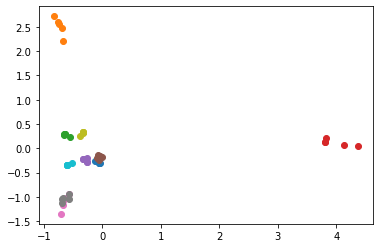

In [98]:
for i in range(to_track_len):
    item = embeddings[i, :, :]
    transformed_item = pca.transform(item)
    plt.scatter(transformed_item[:, 0], transformed_item[:, 1])

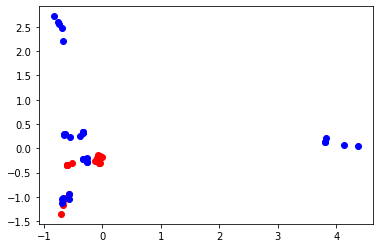

In [102]:
for i in range(to_track_len):
    item = embeddings[i, :, :]
    transformed_item = pca.transform(item)
    if tracked_item_categories[i] == "Women":
        plt.scatter(transformed_item[:, 0], transformed_item[:, 1], color = 'blue')
    if tracked_item_categories[i] == "Men":
        plt.scatter(transformed_item[:, 0], transformed_item[:, 1], color = 'red')